In [ ]:
import os
import logging
from pathlib import Path
import kaggle
import pandas as pd
from prophet import Prophet, serialize
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             mean_absolute_percentage_error, 
                             median_absolute_error)
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
import matplotlib.pyplot as plt
import mlflow
from mlflow import MlflowClient

# Constants
FIGSIZE = (15, 7)

# config kaggle json and download the dataset.
def download_kaggle_dataset(file_path: str, kaggle_dataset: str = "pratyushakar/rossmann-store-sales") -> None:
    if os.path.exists(file_path):
        logging.info("Dataset already exists!")
    else:
        logging.info("Dataset not found, Downloading ...")
        kaggle.api.dataset_download_files(kaggle_dataset, path='./data', unzip=True, quiet=False)

def prep_store_data(df: pd.DataFrame, store_id: int = 4, store_open: int = 1) -> pd.DataFrame:
    df["Date"] = pd.to_datetime(df["Date"])
    df_store = df[
        (df["Store"] == store_id ) &\
        (df["Open"] == store_open)
    ].reset_index(drop=True)
    return df_store.sort_values("Date", ascending=True)

def rename_cols(df: pd.DataFrame, feature: str) -> None:
    df.rename(columns = {"Date": "ds", feature: "y"}, inplace=True)

def train_test_split(df: pd.DataFrame, train_fraction: float) -> tuple[pd.DataFrame, pd.DataFrame, int]:
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]
    return df_train, df_test, train_index

def get_var_name(var, namespace) -> str:
    return [name for name in namespace if namespace[name] is var][0]


def df_date_range_and_period(df: pd.DataFrame) -> int:
    var_name = get_var_name(df, locals())
    logging.info(f"{var_name}:")
    logging.info(f"Data range: {df['ds'].min().strftime('%Y-%m-%d')} -> {df['ds'].max().strftime('%Y-%m-%d')}")
    period = (df['ds'].max() - df['ds'].min()).days + 1
    logging.info(f"Total days: {period}\n")
    return period

def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame, train_index: int, results_path: str) -> None:
    fig, ax = plt.subplots(figsize=FIGSIZE)
    df_test.plot(
        x="ds",
        y="y",
        ax=ax,
        label="Truth",
        linewidth=1,
        markersize=5,
        color="tab:blue",
        alpha=0.9,
        marker="o"
    )
    predicted.plot(
        x="ds",
        y="yhat",
        ax=ax,
        label="Prediction + 95% CI",
        linewidth=2,
        markersize=5,
        color="red"
    )
    ax.fill_between(
        x=predicted["ds"],
        y1=predicted["yhat_upper"],
        y2=predicted["yhat_lower"],
        alpha=0.15,
        color="red"
    )
    df_train.iloc[train_index-100:].plot(
        x="ds",
        y="y",
        ax=ax,
        color='tab:blue',
        label="_nolegend_",
        alpha=0.5,
        marker="o",
    )
    
    yticks = plt.gca().get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels(["{:,.0f}".format(x) for x in yticks])
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    plt.tight_layout()
    plt.savefig(os.path.join(results_path, "store_data_forecast.png"))

def plot_results(model: Prophet, forecast_prophet: pd.DataFrame, df_test: pd.DataFrame, future_period: int , store_id: int) -> None:
    # plot the time series 
    forecast_plot = model.plot(forecast_prophet, figsize=FIGSIZE)

    # add a vertical line at the end of the training period
    axes = forecast_plot.gca()
    last_training_date = forecast_prophet['ds'].iloc[-future_period]
    axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')
    plt.title(f"Daily sales of store id: {store_id}")
    # plot true test data for the period after the red line
    plt.plot(df_test['ds'], df_test['y'],'ro', markersize=3, label='True Test Data')

    # show the legend to distinguish between the lines
    plt.legend()

def plot_seasonal_decompose(decompose : DecomposeResult, plot: bool = True) -> None:
    if(plot):
        fig = decompose.plot()
        fig.set_size_inches(FIGSIZE)
        fig.tight_layout()
        plt.show()
    else:
        logging.INFO("plot_seasonal_decompose deactivated")

def plot_df(df: pd.DataFrame) -> None:
    ax = df.set_index('ds').plot(figsize=FIGSIZE)
    ax.set_xlabel('Date')
    plt.show()


def extract_params(model) -> dict:
    return {attr: getattr(model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}


2025/04/09 19:27:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/04/09 19:27:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025-04-09 19:27:47,934 - root - INFO - Defined MLFlowClient and set tracking URI.
2025-04-09 19:27:47,935 - root - INFO - Dataset already exists!
/tmp/ipykernel_219923/634870614.py:24: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


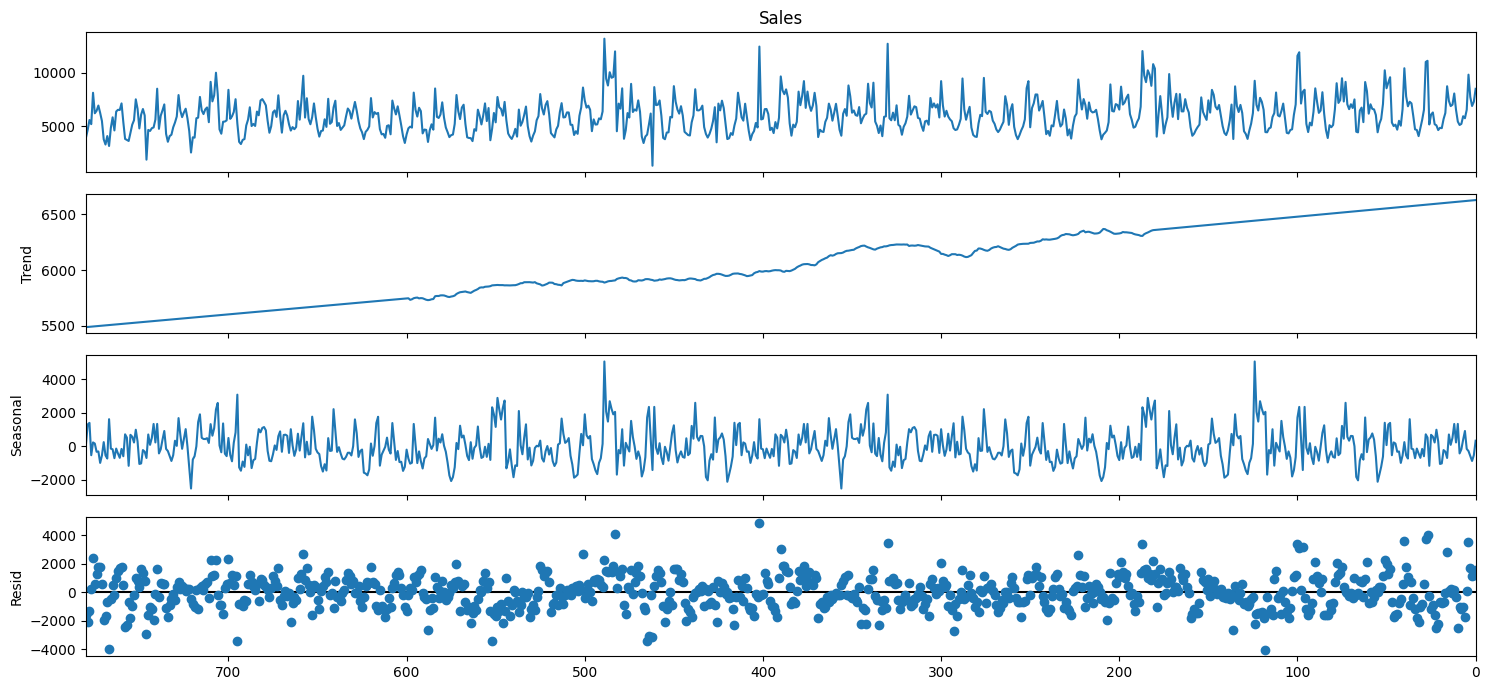

2025-04-09 19:27:48,960 - root - INFO - df:
2025-04-09 19:27:48,962 - root - INFO - Data range: 2013-01-02 -> 2015-07-31
2025-04-09 19:27:48,962 - root - INFO - Total days: 941

2025-04-09 19:27:48,963 - root - INFO - df:
2025-04-09 19:27:48,964 - root - INFO - Data range: 2013-01-02 -> 2014-09-18
2025-04-09 19:27:48,964 - root - INFO - Total days: 625

2025-04-09 19:27:48,965 - root - INFO - df:
2025-04-09 19:27:48,966 - root - INFO - Data range: 2014-09-19 -> 2015-07-31
2025-04-09 19:27:48,967 - root - INFO - Total days: 316

2025-04-09 19:27:49,003 - cmdstanpy - DEBUG - input tempfile: /tmp/tmpj_a0he8q/0cvg9l32.json
2025-04-09 19:27:49,030 - cmdstanpy - DEBUG - input tempfile: /tmp/tmpj_a0he8q/dzdr57sc.json
2025-04-09 19:27:49,031 - cmdstanpy - DEBUG - idx 0
2025-04-09 19:27:49,032 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-04-09 19:27:49,033 - cmdstanpy - DEBUG - CmdStan args: ['/home/agsa/Documents/Projects/Personal_projects/Forecasting_ML_microservice/train/.ve

🏃 View run bouncy-shark-230 at: http://127.0.0.1:5000/#/experiments/250329204548197133/runs/f6a06e952a04420b9addb39daf9cec23
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/250329204548197133


/tmp/ipykernel_219923/634870614.py:82: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


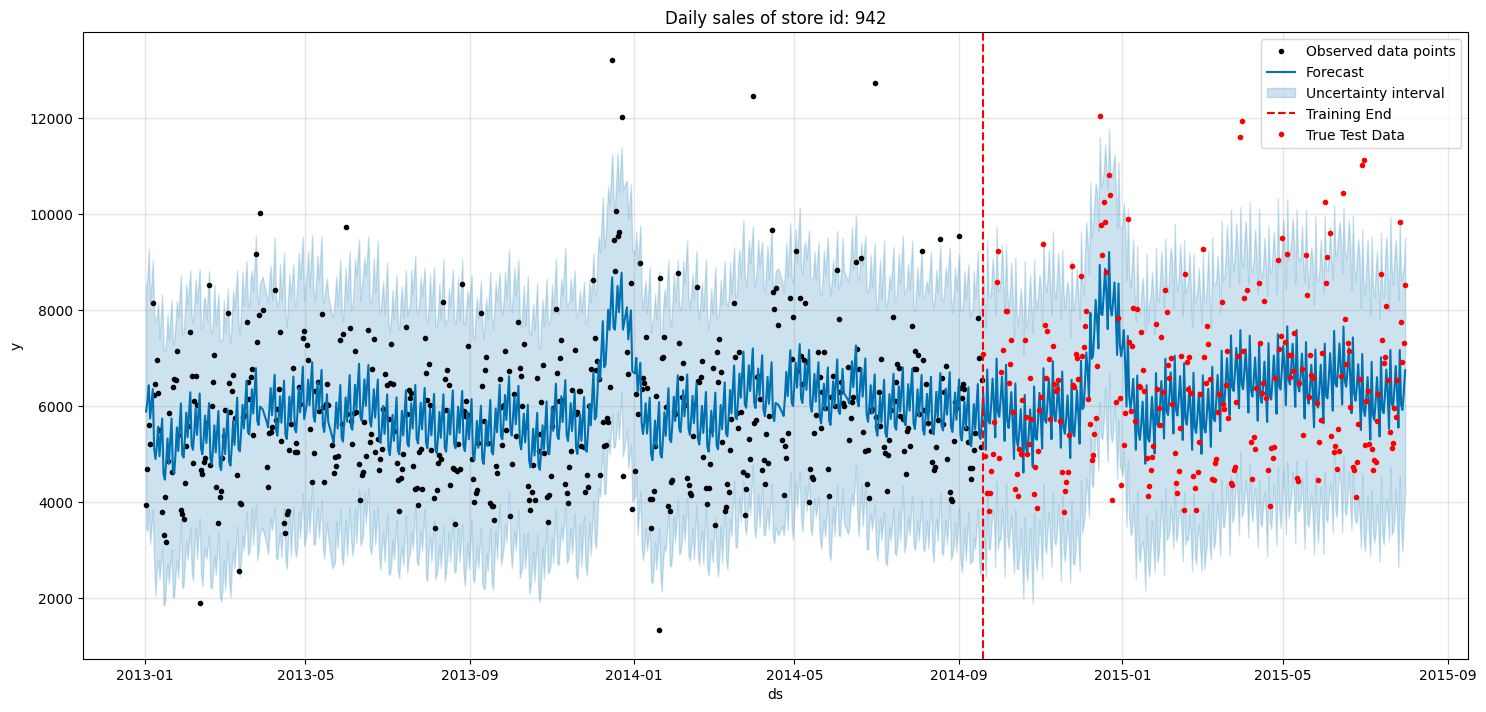

In [ ]:
def main():
    results_path = "./results/"
    Path(results_path).mkdir(exist_ok=True)
    data_path = "./data/"
    train_file = "train.csv"
    file_path = os.path.join(data_path, train_file)
    kaggle_dataset = "pratyushakar/rossmann-store-sales"

    ARTIFACT_PATH = "model"

    log_format = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
    logging.basicConfig(format = log_format, level = logging.INFO)

    tracking_uri = "http://127.0.0.1:5000"
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment("prophet_models_04042025")
    mlflow.autolog()
    client = MlflowClient(tracking_uri=tracking_uri) 
    logging.info("Defined MLFlowClient and set tracking URI.")


    download_kaggle_dataset(file_path, kaggle_dataset) 

    df = pd.read_csv(file_path)

    store_id=942 
    df = prep_store_data(df, store_id) # maxi_val= 942
    decompose = seasonal_decompose(df.Sales, model='additive', extrapolate_trend='freq', period=365)
    plot_seasonal_decompose(decompose, plot = True)

    rename_cols(df, "Sales")

    with mlflow.start_run():
        model_name = f"prophet-retail-forecaster-store-{store_id}"

        df_train, df_test, train_index = train_test_split(df, train_fraction=2/3)

        _ = df_date_range_and_period(df)
        train_period = df_date_range_and_period(df_train)
        future_period = df_date_range_and_period(df_test)

        seasonality = {
            "yearly": True,
            "weekly": True,
            "daily": False,
        }

        model = Prophet(
            yearly_seasonality = seasonality["yearly"],
            weekly_seasonality = seasonality["weekly"],
            daily_seasonality = seasonality["daily"],
            interval_width = 0.95
        )

        model.fit(df_train)
        run_id = mlflow.active_run().info.run_id

        mlflow.prophet.log_model(model, artifact_path=ARTIFACT_PATH, signature=False, input_example=df_train) # or provide signature without df_train

        df_future = model.make_future_dataframe(periods=future_period, freq="D", include_history=True)

        df_predicted = model.predict(df_future)
        df_predicted[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

        mlflow.log_params(seasonality)
        mlflow.log_metrics(
            {
                'rmse': mean_squared_error(y_true=df_test['y'], y_pred=model.predict(df_test)['yhat']),
                'mean_abs_perc_error': mean_absolute_percentage_error(y_true=df_test['y'], y_pred=model.predict(df_test)['yhat']),
                'mean_abs_error': mean_absolute_error(y_true=df_test['y'], y_pred=model.predict(df_test)['yhat']),
                'median_abs_error': median_absolute_error(y_true=df_test['y'], y_pred=model.predict(df_test)['yhat'])
            }
        )

    model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_id, artifact_path=ARTIFACT_PATH)
    model_details = mlflow.register_model(model_uri=model_uri, name=model_name)
    logging.info("Model registered")

    plot_results(model, df_predicted, df_test, future_period, store_id)
    client.transition_model_version_stage(
        name=model_details.name,
        version=model_details.version,
        stage='production',
    )

if __name__ == "__main__":
    main()


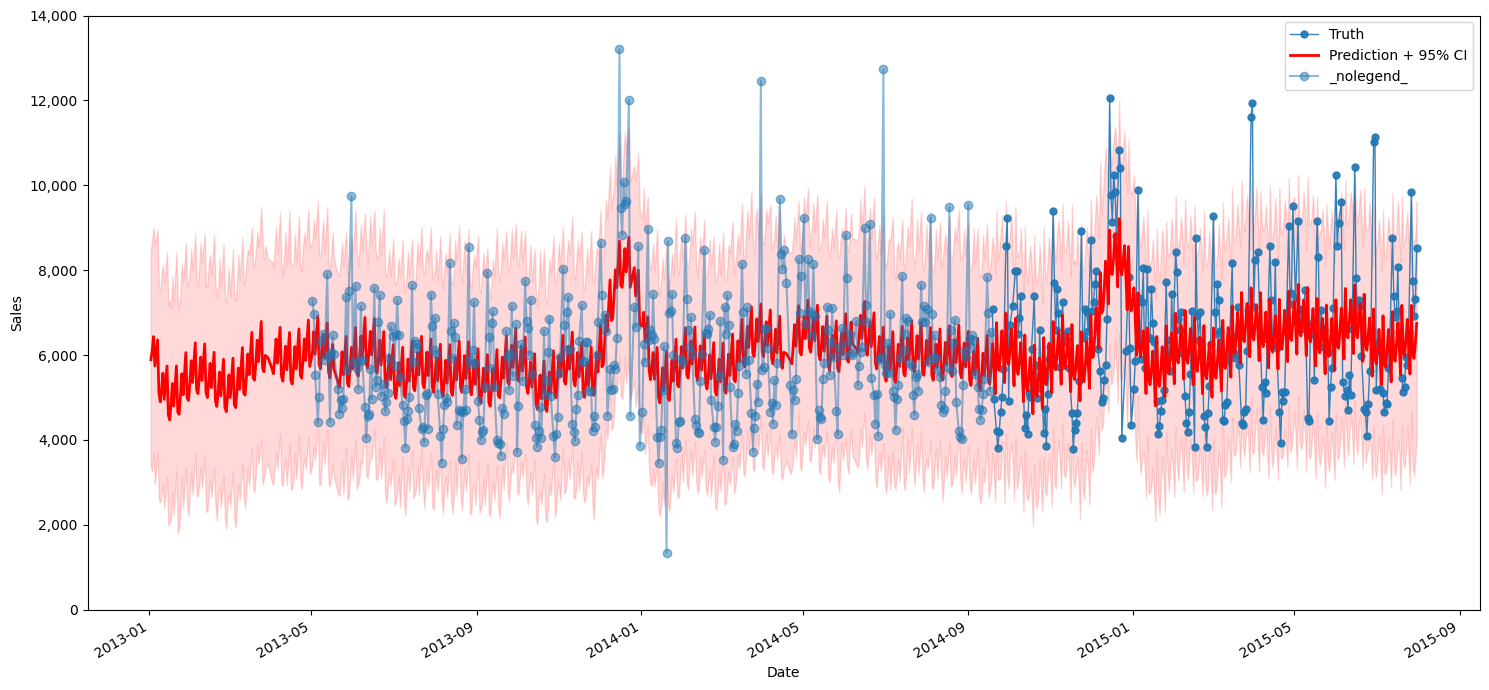

In [67]:
plot_forecast(df_train, df_test, forecast_prophet, 100, results_path)